In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import re

from utils import *
from matplotlib import pyplot as plt
from pymongo import MongoClient

### Parâmetros do matplot e Seaborn

In [2]:
%matplotlib inline
pd.options.mode.chained_assignment = None 
plt.rcParams['figure.figsize'] = [10, 5]
sns.set(rc={'figure.figsize':(15,10)})

### Recuperação de Datasets do MongoDB

In [3]:
df_meteorologia_2010_2019 = mongo_to_dataframe("meteorologia_2010_2019")

In [4]:
df_acidentes_fatais_2008_2017 = mongo_to_dataframe("acidentes_fatais_2008_2017")

In [5]:
df_acidentes_rodovias_2010_2019 = mongo_to_dataframe("acidentes_rodovias_2010_2019")

In [ ]:
df_infracoes_prf_2010_2018 = mongo_to_dataframe("infracoes_prf_2010_2018")

In [ ]:
df_infracoes_der_2018_2019 = mongo_to_dataframe("infracoes_der_2018_2019")

## Análise dos acidentes fatais em relação com condições climáticas

### Observações
- A correlação de Pearson, tanto dos acidentes nas rodovias quanto dos dados do DER deram por volta de -0,3. Esse resultado mostra que é uma correlação negativa fraca.
- Com isso, meses com índices de precipitação mais altos não necessariamente são aqueles com mais acidentes.

In [6]:
dict_meses = {1: 'Janeiro',
              2: 'Fevereiro',
              3: 'Março',
              4: 'Abril',
              5: 'Maio',
              6: 'Junho',
              7: 'Julho',
              8: 'Agosto',
              9: 'Setembro',
              10: 'Outubro',
              11: 'Novembro',
              12: 'Dezembro'}

Text(0, 0.5, 'Precipitação (mm)')

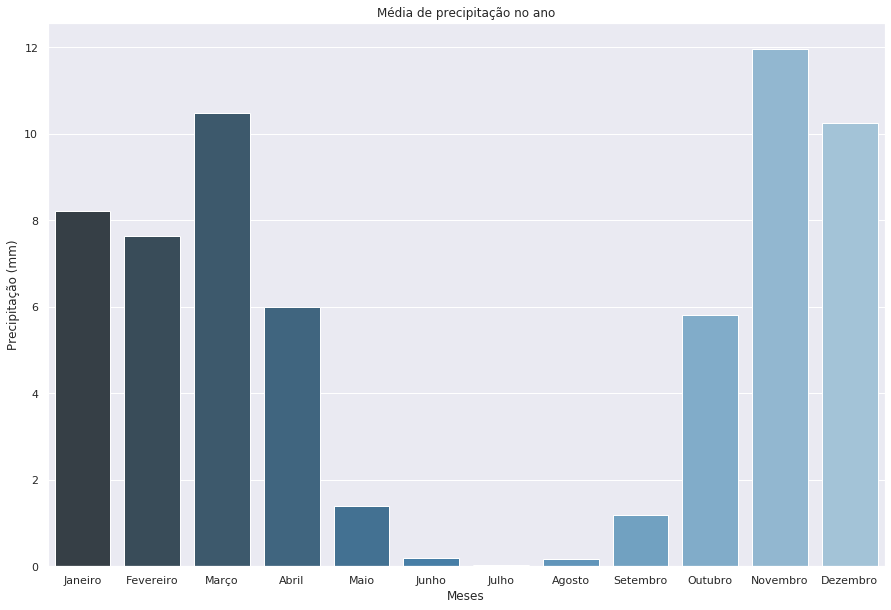

In [7]:
df_meteorologia_2010_2019['Mes'] = df_meteorologia_2010_2019['Data'].dt.month
media_precipitacao_meses = df_meteorologia_2010_2019.groupby('Mes').mean().reset_index()
media_precipitacao_meses = media_precipitacao_meses[['Mes', 'Precipitacao']]

media_precipitacao_meses['Mes'] = media_precipitacao_meses['Mes'].replace(dict_meses)
sns.barplot(x = media_precipitacao_meses['Mes'], y = media_precipitacao_meses['Precipitacao'], data = media_precipitacao_meses, palette = "Blues_d")
plt.title("Média de precipitação no ano")
plt.xlabel("Meses")
plt.ylabel("Precipitação (mm)")

Text(0, 0.5, 'Média de acidentes')

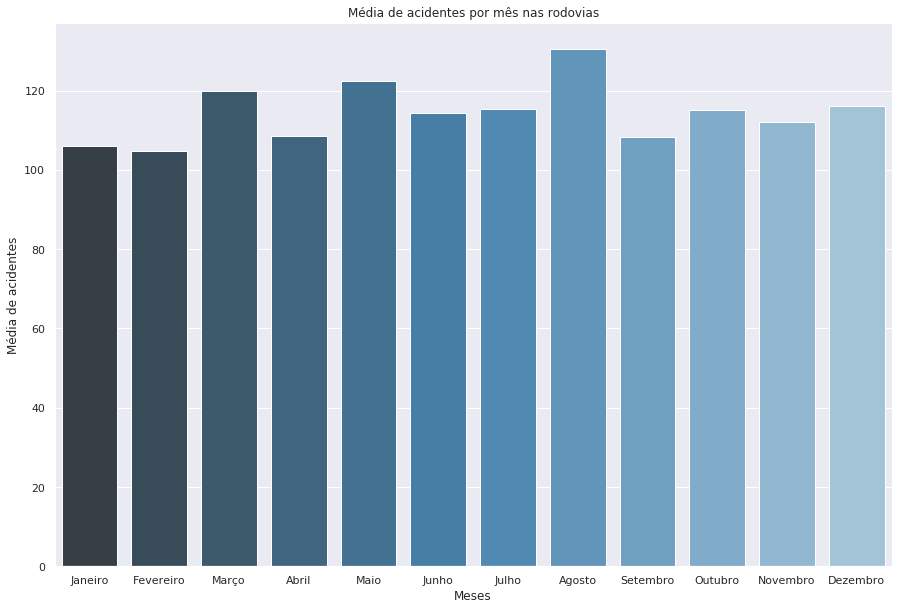

In [8]:
df_acidentes_rodovias_2010_2019['Mes'] = df_acidentes_rodovias_2010_2019['data_inversa'].dt.month
media_acidentes_rodovias_meses = df_acidentes_rodovias_2010_2019.groupby('Mes').count().reset_index()
media_acidentes_rodovias_meses[media_acidentes_rodovias_meses.Mes <= 7] = media_acidentes_rodovias_meses / 9
media_acidentes_rodovias_meses[media_acidentes_rodovias_meses.Mes > 7] = media_acidentes_rodovias_meses / 8
media_acidentes_rodovias_meses['Mes'] = media_acidentes_rodovias_meses.index + 1
media_acidentes_rodovias_meses = media_acidentes_rodovias_meses[['Mes', 'causa_acidente']]

media_acidentes_rodovias_meses['Mes'] = media_acidentes_rodovias_meses['Mes'].replace(dict_meses)
sns.barplot(x = media_acidentes_rodovias_meses['Mes'], y = media_acidentes_rodovias_meses['causa_acidente'], data = media_acidentes_rodovias_meses, palette = "Blues_d")
plt.title("Média de acidentes por mês nas rodovias")
plt.xlabel("Meses")
plt.ylabel("Média de acidentes")

Text(0, 0.5, 'Média de acidentes fatais')

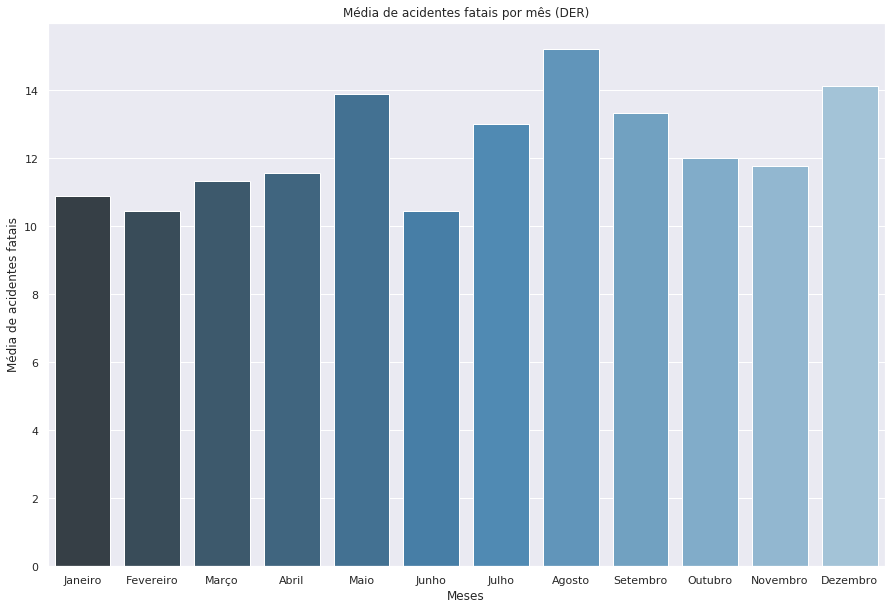

In [9]:
df_acidentes_fatais_2008_2017['Data'] = pd.to_datetime(df_acidentes_fatais_2008_2017['Data'], dayfirst=True)
df_acidentes_fatais_2008_2017['Mes'] = df_acidentes_fatais_2008_2017['Data'].dt.month
media_acidentes_der_meses = df_acidentes_fatais_2008_2017.groupby('Mes').count().reset_index()
media_acidentes_der_meses['Natureza'] = media_acidentes_der_meses['Natureza'] / 9
media_acidentes_der_meses = media_acidentes_der_meses[['Mes', 'Natureza']]
media_acidentes_der_meses['Mes'] = media_acidentes_der_meses['Mes'].replace(dict_meses)
media_acidentes_der_meses

sns.barplot(x = media_acidentes_der_meses['Mes'], y = media_acidentes_der_meses['Natureza'], data = media_acidentes_der_meses, palette = "Blues_d")
plt.title("Média de acidentes fatais por mês (DER)")
plt.xlabel("Meses")
plt.ylabel("Média de acidentes fatais")

In [10]:
medias_acidentes_precipitacao = pd.merge(media_precipitacao_meses, media_acidentes_rodovias_meses, left_on='Mes', right_on='Mes')
medias_acidentes_precipitacao = medias_acidentes_precipitacao.merge(media_acidentes_der_meses, on='Mes')
medias_acidentes_precipitacao = medias_acidentes_precipitacao.rename(columns={"causa_acidente": "Acidentes Rodovias", "Natureza": "Acidentes Fatais (DER)"})
medias_acidentes_precipitacao

,Mes,Precipitacao,Acidentes Rodovias,Acidentes Fatais (DER)
0,Janeiro,8.204516,106.000000,10.888889
1,Fevereiro,7.641489,104.666667,10.444444
2,Março,10.480645,119.888889,11.333333
3,Abril,6.002333,108.444444,11.555556
4,Maio,1.386774,122.555556,13.888889
5,Junho,0.184333,114.333333,10.444444
6,Julho,0.032581,115.333333,13.000000
7,Agosto,0.170874,130.625000,15.222222
8,Setembro,1.196296,108.375000,13.333333
9,Outubro,5.809319,115.125000,12.000000


In [11]:
def correlaciona_acidentes_precipitacao(acidentes):
    corr_acidentes_precipitacao = medias_acidentes_precipitacao[acidentes].corr(medias_acidentes_precipitacao['Precipitacao'])    

    print('Valor da correlação: {}'.format(corr_acidentes_precipitacao))
    sns.regplot(x = medias_acidentes_precipitacao['Precipitacao'], y = medias_acidentes_precipitacao[acidentes], data = medias_acidentes_precipitacao, fit_reg = True)
    plt.title("Correlação entre a média de precipitação e " + acidentes)
    plt.show()

Valor da correlação: -0.3359042769725179


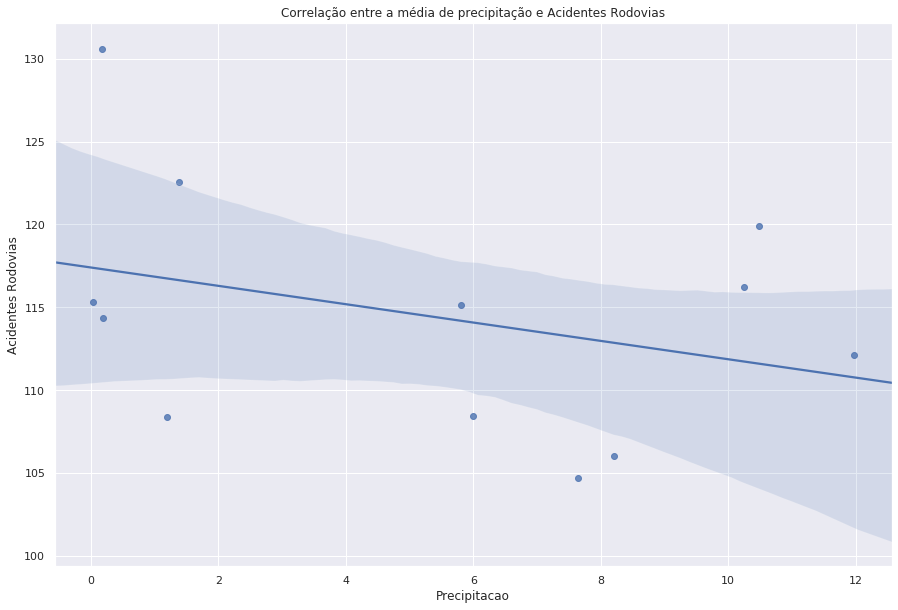

In [12]:
correlaciona_acidentes_precipitacao('Acidentes Rodovias')

Valor da correlação: -0.36704298958002474


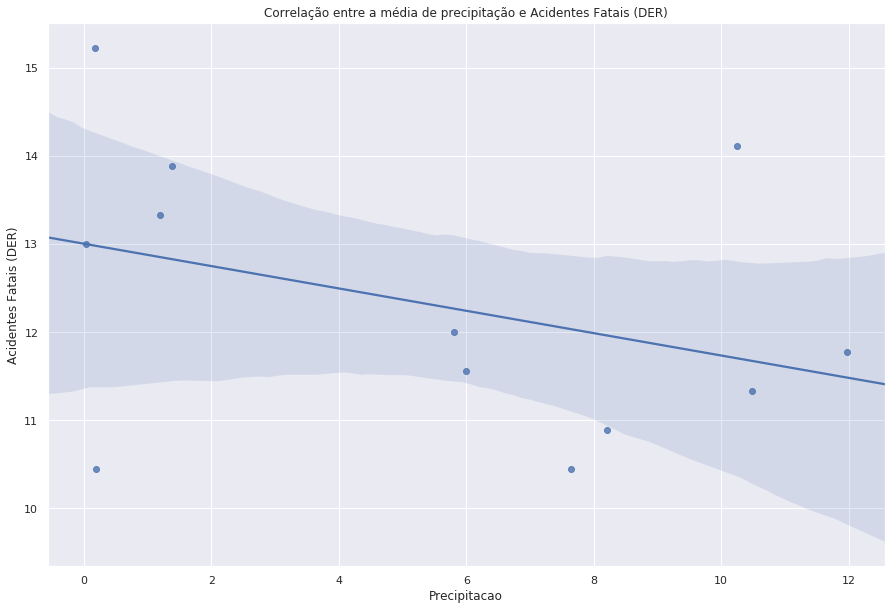

In [13]:
correlaciona_acidentes_precipitacao('Acidentes Fatais (DER)')

In [14]:
df_acidentes_rodovias_2010_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11781 entries, 0 to 11780
Data columns (total 25 columns):
data_inversa              11781 non-null datetime64[ns]
dia_semana                11781 non-null object
horario                   11781 non-null object
uf                        11781 non-null object
br                        11776 non-null float64
km                        11776 non-null object
causa_acidente            11781 non-null object
tipo_acidente             11781 non-null object
classificacao_acidente    11781 non-null object
fase_dia                  11781 non-null object
sentido_via               11781 non-null object
condicao_metereologica    11781 non-null object
tipo_pista                11781 non-null object
tracado_via               11781 non-null object
uso_solo                  11781 non-null object
ano                       11781 non-null int64
pessoas                   11781 non-null int64
mortos                    11781 non-null int64
feridos_leves        